# Lecture 12: Computing Rips Complex Persistence for a Point Cloud

## Installing packages 

This tutorial will be based on the following packages. 
- [Teaspoon](https://teaspoontda.github.io/teaspoon/) 
- [Scikit-TDA](https://docs.scikit-tda.org/en/latest/)

Also note that some figures in this notbook are done in `plotly`. However, these figures do not render on the website. Be sure to download the notebook to see them. 

Uncomment and run the commands below if these packages are not already installed in your system. 


In [1]:
# !pip install teaspoon 
# !pip install scikit-tda

In [2]:
import ripser # This is in the scikit-tda package
from persim import plot_diagrams # Also in scikit-tda


import teaspoon.MakeData.PointCloud as gPC
import teaspoon.TDA.Draw as Draw

# Standard imports 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial import distance_matrix
import plotly.express as px
import plotly.graph_objects as go


%matplotlib inline

Next, we're going to compute persistence for a point cloud using the Rips filtration. 

This section requires `ripser` (from `scikit-tda`) and `teaspoon` installed. `Ripser` is a package that is very optimized for point cloud Rips persistence. 

## Rips Definition 

The setup for persistence in this section is as follows. 
- We are given a point cloud $P = \{x_0, \ldots,x_{N-1}\} \subseteq \mathbb{R}^d$
- The Vietoris-Rips complex is defined by $VR(P, r) = \{ \sigma \subseteq P \mid \|x_i-x_j\| \leq r \; \forall x_i,x_j \in \sigma\} $
    - Note that I'm not using the $2r$ from the book since this is what usually shows up in code.
- Persistence module: $H_p(VR(P,0)) \to H_p(VR(P,r_1)) \to \cdots H_p(VR(P,r_N))$
- **Goal**: Compute persistence diagram of this module and draw persistence diagram 


## Tiny example 

Let's compute the Rips complex for a tiny example: a point cloud with just 6 points. I've got them labeled with their order in the matrix $P$. 

In [34]:
P = np.array([[0,0],[1,0],[0,2],[1,1.5],[0.5,0.5],[2,2], [2,0.5], [2.5,1]])
P

array([[0. , 0. ],
       [1. , 0. ],
       [0. , 2. ],
       [1. , 1.5],
       [0.5, 0.5],
       [2. , 2. ],
       [2. , 0.5],
       [2.5, 1. ]])

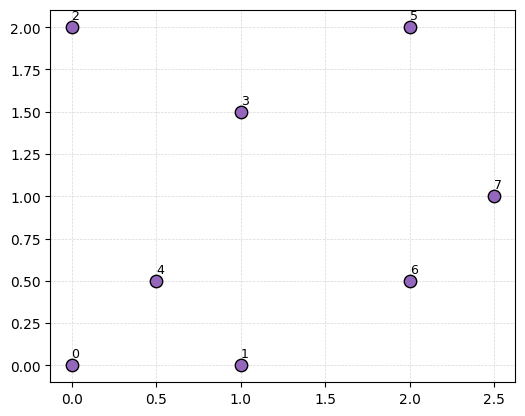

In [4]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(P[:,0], P[:,1], color='tab:purple', edgecolors = 'k', s=80, zorder=3)
labels = [f"{i}" for i in range(len(P))]
for i, txt in enumerate(labels):
    ax.text(P[i,0], P[i,1]+0.03, txt, ha='left', va='bottom', fontsize=9, zorder=4)
ax.set_aspect('equal', 'box')
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', alpha=0.9)
plt.show()

Remember, for any fixed radius $r$, the Rips complex has all edges for pairs of points $x$ and $y$ that are within distance $r$ of each other; and then all higher dimensional simplicies that are available. 

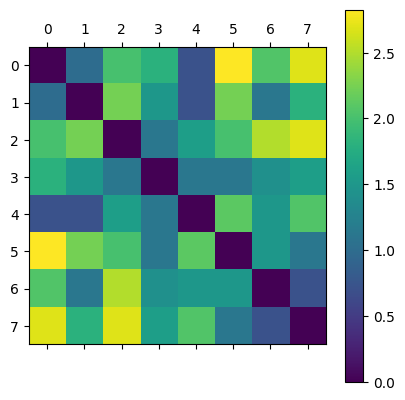

In [5]:
D = distance_matrix(P, P)
plt.matshow(D)
plt.colorbar();

<div style="border:2px solid #e74c3c; border-radius:8px; padding:1em; background:#fff6f6;color:#000000">
<span style="color:#e74c3c; font-weight:bold;">Q:</span> Below is code that will draw an edge between two points if they are a most distance r = 1.3. 
<ul>
<li>What triangles are in VR(P,1.3)? Tetrahedra?</li>
<li> What triangles are in VR(P,1.6)? Tetrahedra?</li>
</ul> 
</div>

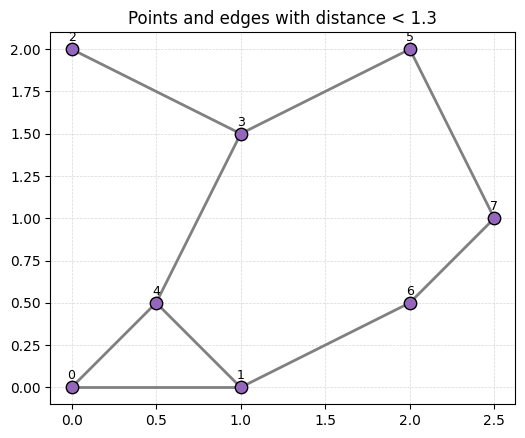

In [37]:
r = 1.3
fig, ax = plt.subplots(figsize=(6,6))
for i in range(len(P)):
    for j in range(i+1, len(P)):
        if D[i, j] < r:
            ax.plot([P[i,0], P[j,0]], [P[i,1], P[j,1]], color='gray', linewidth=2)
ax.scatter(P[:,0], P[:,1], color='tab:purple',
           edgecolors='k', s=80, zorder=3)
labels = [f"{i}" for i in range(len(P))]
for i, txt in enumerate(labels):
    ax.text(P[i,0], P[i,1]+0.03, txt, ha='center', va='bottom', fontsize=9, zorder=4)
ax.set_title(f'Points and edges with distance < {r}')
ax.set_aspect('equal', 'box')
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', alpha=0.9)
plt.show()

<span style="color:gray;">Answer commented out in this cell.</span>
<!-- 
Answer: The only triangle is [0,1,4] for r = 1.3, and no tetrahedron (2-simplex).  
For r=2, there are two tetrahedra: [1,3,4,6] and [3,6,5,7]. Then it has all of the triangles that are faces of those, plus the triangles [2,3,4] and [0,1,4].   -->

The [`ripser` package](https://ripser.scikit-tda.org/en/latest/)., which you installed with the `scikit-tda` package, computes Rips persistence for point clouds. To do this, we need only run the following command and pass in the point cloud `P`. 
The `ripser` package computes persistence of the point cloud for the Rips (aka Vietoris-Rips) complex.  Again, see the 

In [38]:
output = ripser.ripser(P)

print(f"Ripser's output is of type {type(output)}\nwith keys {output.keys()}")

Ripser's output is of type <class 'dict'>
with keys dict_keys(['dgms', 'cocycles', 'num_edges', 'dperm2all', 'idx_perm', 'r_cover'])


We care about the `dgms` portion in this case. It is a list of arrays, the `i`th entry is the `i`-dimensional persistence diagram.

In [8]:
output['dgms']

[array([[0.        , 0.70710677],
        [0.        , 0.70710677],
        [0.        , 0.70710677],
        [0.        , 1.11803401],
        [0.        , 1.11803401],
        [0.        , 1.11803401],
        [0.        , 1.11803401],
        [0.        ,        inf]]),
 array([[1.41421354, 1.5       ],
        [1.11803401, 1.5       ]])]

In [9]:
print('0-dimensional diagram points:')
print(output['dgms'][0])

0-dimensional diagram points:
[[0.         0.70710677]
 [0.         0.70710677]
 [0.         0.70710677]
 [0.         1.11803401]
 [0.         1.11803401]
 [0.         1.11803401]
 [0.         1.11803401]
 [0.                inf]]


In [10]:
print('1-dimensional diagram points:')
print(output['dgms'][1])

1-dimensional diagram points:
[[1.41421354 1.5       ]
 [1.11803401 1.5       ]]


Then we can also use `scikit-tda`'s plotting to visualize this easily.

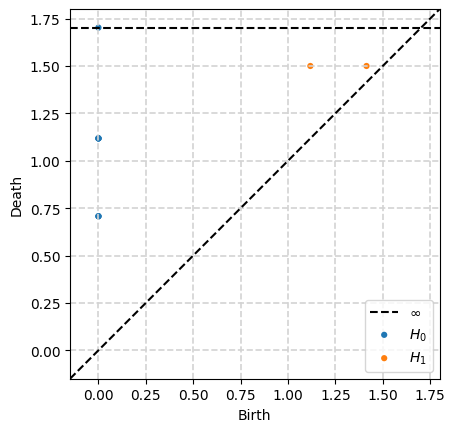

In [41]:
plot_diagrams(output['dgms'])
ax = plt.gca()
ax.grid(True, linestyle='--', linewidth=1.2, color='lightgray', alpha=1)


## Rips for point clouds sampled from spaces

### Annulus

Let's do a more interesting example by computing the persistent homology of a point cloud from an annulus. 

<div style="border:2px solid #e74c3c; border-radius:8px; padding:1em; background:#fff6f6;color:#000000; width:80%">
<span style="color:#e74c3c; font-weight:bold;">Q:</span> Before you move on, what should the homology of an annulus be? <br>
<br>
<a href="https://en.wikipedia.org/wiki/Annulus_(mathematics)" target="_blank"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/Annulus_area.svg/480px-Annulus_area.svg.png" alt="Annulus diagram: Credit, wikipedia" width="300"></a>
<br><em>Image credit: Wikipedia</em>
</div>


<span style="color:gray;">Answer commented out in this cell.</span>
<!-- 
Answer: One connected component, so $\beta_0 = 1$; One loop, so $\beta_1 = 1$. -->

The `teaspoon` has code for creating random point clouds for testing purposes.  In particular, we have the `Annulus` command which generates a point cloud from an annulus.  See the [documentation](https://lizliz.github.io/teaspoon/MakeData.html) for specific usage.


We first generate a point cloud with 200 points from an annulus which has inside radius $r=2$ and outside radius $R=3$. 

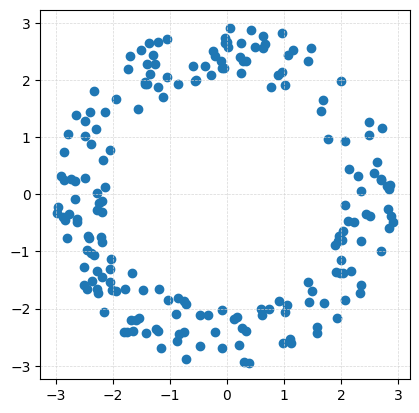

In [43]:
P = gPC.Annulus(N=200, r = 2, R = 3)
Draw.drawPtCloud(P)
ax = plt.gca()
ax.axis('square')
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', alpha=0.9)

In [44]:
P

array([[ 1.76243294,  0.97205737],
       [-1.26672625,  2.27607755],
       [-2.49430639, -1.2800484 ],
       [ 2.83770111,  0.09580523],
       [ 2.8644357 , -0.38387615],
       [ 2.03038535, -1.36911699],
       [ 0.49754451,  2.58180015],
       [ 0.38025519, -2.94497835],
       [ 1.15954566,  2.52816422],
       [-2.04693913,  0.78140259],
       [ 2.22777347, -0.47923324],
       [ 2.3500861 , -1.58805883],
       [ 2.05806357, -1.84835211],
       [-2.04777456, -1.30399017],
       [-2.15252848, -2.06196926],
       [-1.04559809,  2.71517326],
       [-1.21111187, -2.39947752],
       [-2.019565  , -1.68303387],
       [-1.56022083,  1.50040389],
       [ 1.07717745,  2.4392088 ],
       [-0.21604177, -2.40344244],
       [-0.47848901, -2.66142265],
       [-0.02776209,  2.6492904 ],
       [-2.90595973,  0.3210419 ],
       [-1.46636893, -1.66905686],
       [ 0.90625111, -1.86529861],
       [-2.49340269,  0.28944743],
       [ 2.84324216, -0.59631852],
       [ 1.48364243,

Then computing persistence is one line. Note that ripser defaults to only computing up to 1-dimensional persistence unless you tell it otherwise. For fun, I'm telling it to go up to 2-dimensional persistence. 

In [13]:
output = ripser.ripser(P,maxdim=2)
dgms = output['dgms']
print(f"2-dimensional diagram points:")
print(dgms[2])  

2-dimensional diagram points:
[[3.70902872 3.72065973]
 [3.64157963 3.69366431]
 [3.63115883 3.91910648]]


Then we can plot the resulting diagram. 

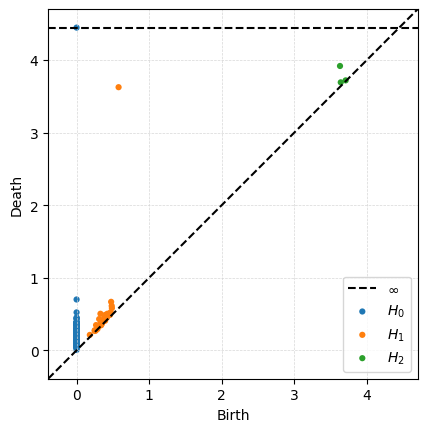

In [14]:
plot_diagrams(dgms)
ax = plt.gca()
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', alpha=0.9)

<div style="border:2px solid #e74c3c; border-radius:8px; padding:1em; background:#fff6f6;color:#000000; width:80%">
<span style="color:#e74c3c; font-weight:bold;">Q:</span> Does this diagram fit with your expectation from the homolgy of the annulus?  
</div>


### Sphere
The following code will generate a point cloud drawn from a sphere. Note this is done with plotly, so will not render on the website. Download the jupyter notebook to see it. 


In [15]:
P_sphere = gPC.Sphere(300)
# Create a 3d plot of the sphere using plotly 
fig = px.scatter_3d(x=P_sphere[:,0], y=P_sphere[:,1], z=P_sphere[:,2])
fig.update_traces(marker=dict(size=3))
fig.show()

<div style="border:2px solid #e74c3c; border-radius:8px; padding:1em; background:#fff6f6;color:#000000; width:80%">
<span style="color:#e74c3c; font-weight:bold;">Q:</span> 
<ul>
<li> What is the homology of the sphere?</li>
<li> Compute the persistence diagram for the sphere point cloud. Does this fit with what you said above?</li>
<li> Increase the number of points in the sphere to 400 and compute its persistence diagram. Do the same for 100 points and 500 points (although you might need to be patient, my laptop took about 30 seconds for that last one). What changes in the diagram??</li>
</ul>
</div>


In [16]:
# Your code here

### Torus

Here's a point cloud sampled from a torus, with inner radius $r=1$ and outer radius $R=2$. Again note that the figure is done with plotly, so will not work on the website.  


<a href="https://en.wikipedia.org/wiki/Torus" target="_blank"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Tesseract_torus.png/960px-Tesseract_torus.png" alt="Annulus diagram: Credit, wikipedia" width="300"></a><br>
*Image: Wikipedia*

In [17]:
P_torus = gPC.Torus(200)
fig = px.scatter_3d(x=P_torus[:,0], y=P_torus[:,1], z=P_torus[:,2])
fig.update_traces(marker=dict(size=3))
fig.show()

<div style="border:2px solid #e74c3c; border-radius:8px; padding:1em; background:#fff6f6;color:#000000; width:80%">
<span style="color:#e74c3c; font-weight:bold;">Q:</span> 
<ul>
<li> What is the homology of the torus?</li>
<li> Compute the persistence diagram for the torus point cloud. Does this fit with what you said above? <em>Hint: If it doesn't, try increasing the number of points in the point cloud.</em></li>
<li> What is different between this diagram and the sphere diagram?</li>
</ul>
</div>


In [18]:
# Put your code here. 

## Properties of Rips Persistence
### Running times

One important feature to notice is that you should only be computing persistence up to the dimension you care about since the running time gets way worse with more simplices. 

In [45]:
P_torus = gPC.Torus(300) 
# Note: If you want to see a major difference in running times, increase the number of points here.

In [46]:
%%time
# Here the code is computing up to 1 dimensional homology, and jupyter will print out the running time. 
output = ripser.ripser(P_torus, maxdim=1)


CPU times: user 52.7 ms, sys: 6.46 ms, total: 59.1 ms
Wall time: 57.8 ms


In [47]:
%%time
# Here the code is computing up to 2 dimensional homology, and jupyter will print out the running time. 
output = ripser.ripser(P_torus, maxdim=2)


CPU times: user 764 ms, sys: 29.8 ms, total: 793 ms
Wall time: 794 ms


In [48]:
%%time
# Here the code is computing up to 3 dimensional homology, and jupyter will print out the running time. 
# Warning: this may take a while!
output = ripser.ripser(P_torus, maxdim=3)


CPU times: user 30.7 s, sys: 2.08 s, total: 32.7 s
Wall time: 33.2 s


### Special case of 0-dimensional Rips persistence

Note that in this setting, all vertices enter at $r=0$, so all connected components are born at 0. This means the only thing interesting about 0-dimensional Rips persistence is the distribution of death times. 

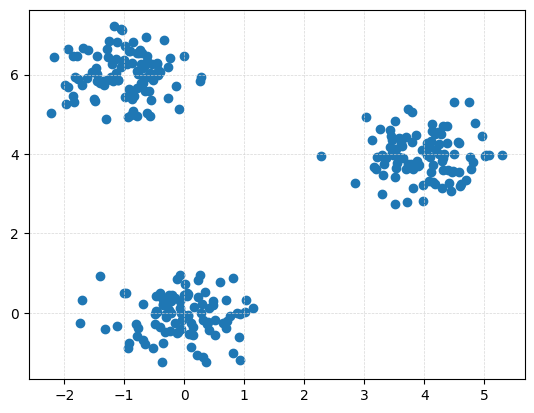

In [49]:
P_clusters = gPC.Clusters(N = 300, centers = np.array([[0,0], [4,4], [-1,6]]), sd = .3)
Draw.drawPtCloud(P_clusters)
ax = plt.gca()
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', alpha=0.9)                     

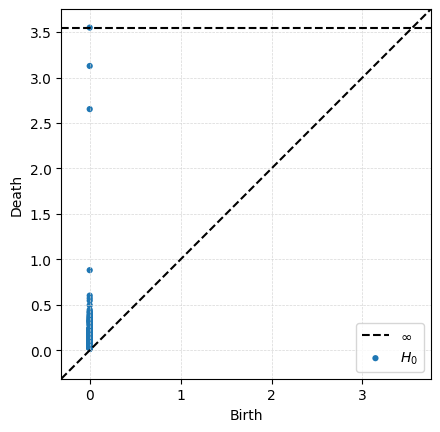

In [50]:
Dgms_clusters = ripser.ripser(P_clusters, maxdim = 1)['dgms']
plot_diagrams(Dgms_clusters[0])
ax = plt.gca()
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', alpha=0.9)

One option for visualization is to draw a histogram of the death times. In this case, I draw it horizontally since that matches with the death axis in the persistence diagrams.

Text(0, 0.5, 'Death time')

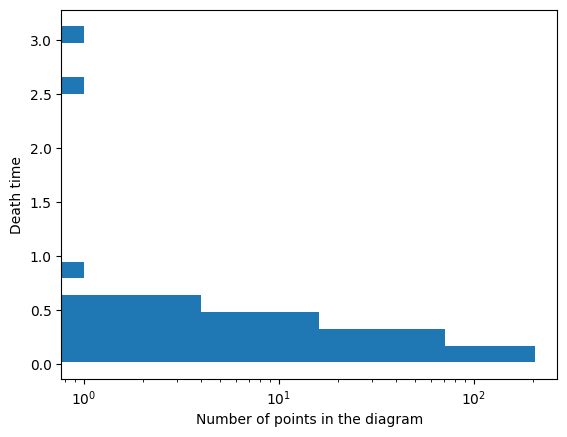

In [51]:
Dgm0 = Dgms_clusters[0][:,1]    # Just keep the death times
Dgm0 = Dgm0[~np.isinf(Dgm0)] # Drop the infinite bar because can't plot that
Dgm0
plt.hist(Dgm0,log=True,orientation = 'horizontal',bins = 20)
plt.xlabel('Number of points in the diagram')
plt.ylabel('Death time')

### Persistence for similar point clouds

If we generate a bunch of random point clouds drawn from the same distribution, the persistence diagrams won't be exactly the same, but they will have similar structure.  



Here's two point clouds, each pulled from an annulus with $N = 200, r = 1, R = 2$ and draw their one-dimensional persistence diagrams on top of each other.

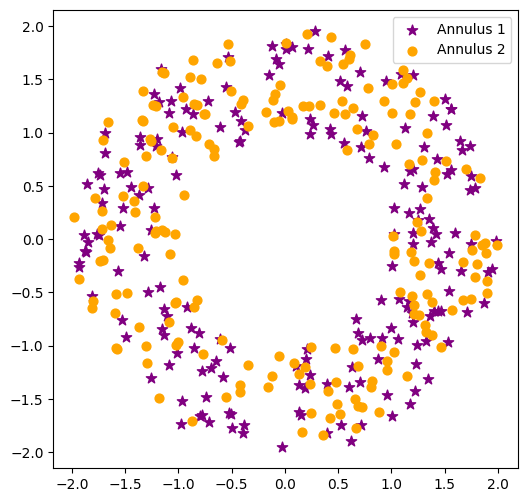

In [26]:
P1 = gPC.Annulus(200,1,2)
P2 = gPC.Annulus(200,1,2)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(P1[:,0], P1[:,1], marker='*', color='purple', s=60, label='Annulus 1')
plt.scatter(P2[:,0], P2[:,1], marker='o', color='orange', s=40, label='Annulus 2')
plt.gca().set_aspect('equal', 'box')
plt.legend()

We compute the persistence for the two point clouds first.

In [27]:
Dgms1 = ripser.ripser(P1)['dgms']
Dgms2 = ripser.ripser(P2)['dgms']

Then we can take a look at the two diagrams. Here's the entirety of both diagrams in both dimension 0 and 1 side by side. 

Text(0.5, 1.0, 'Annulus 2')

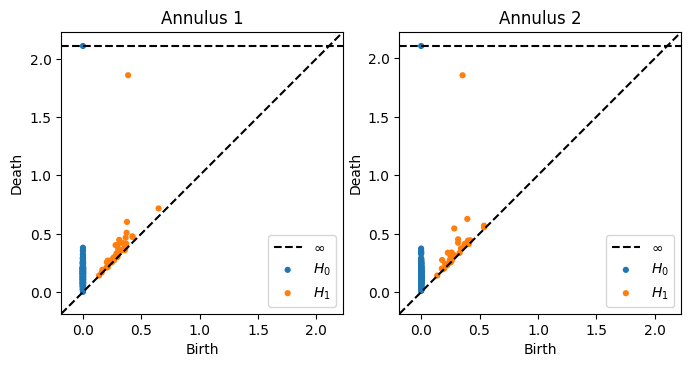

In [28]:
fig, ax = plt.subplots(1,2,figsize = (8,4))
plot_diagrams(Dgms1, ax = ax[0])
ax[0].set_title('Annulus 1')

plot_diagrams(Dgms2, ax = ax[1])
ax[1].set_title('Annulus 2')


In order to see the comparison better, let's draw the two 1-dimensional diagrams on top of each other. 

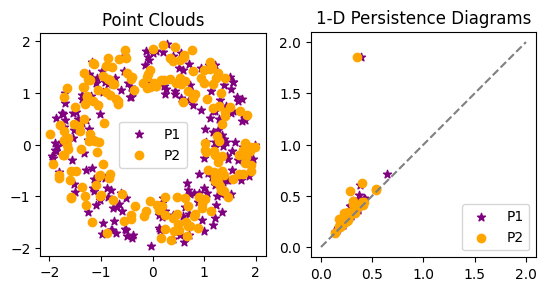

In [29]:
fig, ax = plt.subplots(1,2)

ax[0].scatter(P1[:,0], P1[:,1], marker = '*', color = 'purple', label = 'P1')
ax[0].scatter(P2[:,0], P2[:,1], color = 'orange', label = 'P2')
ax[0].legend()
ax[0].set_aspect('equal', 'box')
ax[0].set_title('Point Clouds')

ax[1].plot([0,2],[0,2], color='gray', linestyle='--')
ax[1].scatter(Dgms1[1][:,0], Dgms1[1][:,1], marker = '*', color = 'purple', label = 'P1')
ax[1].scatter(Dgms2[1][:,0], Dgms2[1][:,1], color = 'orange', label = 'P2')
ax[1].axis('square')
ax[1].set_title('1-D Persistence Diagrams')
ax[1].legend();

<div style="border:2px solid #e74c3c; border-radius:8px; padding:1em; background:#fff6f6;color:#000000; width:80%">
<span style="color:#e74c3c; font-weight:bold;">Q:</span> 
<ul>
<li> What do you notice about the two persistence diagrams?</li>
<li> Overlay the 1-dimensional torus diagram from earlier. What do you see? Which are more similar: the two annuli diagrams, or an annulus and the torus? </li>
</ul>
</div>

In [30]:
# Your code here

### Changing the radius on the annulus

Below is code to compute the persistence of the annulus with the default parameters. 

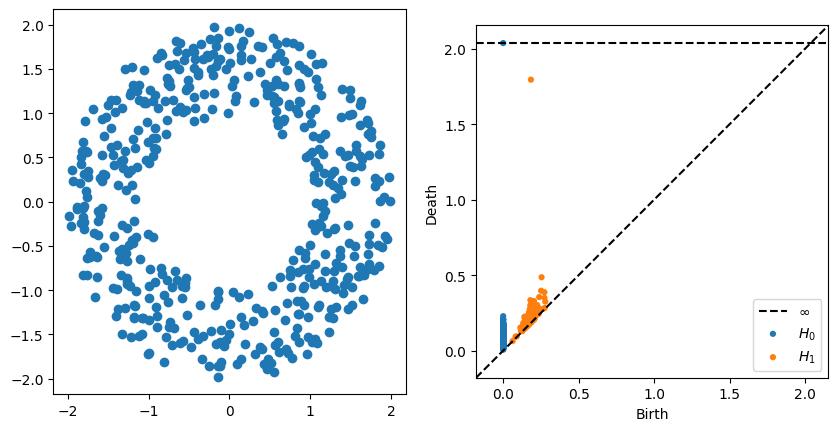

In [52]:
P = gPC.Annulus(500,r = 1, R = 2)
Dgms = ripser.ripser(P)['dgms']
fig, axs = plt.subplots(1,2, figsize = (10,5))
plt.sca(axs[0])
Draw.drawPtCloud(P)
plt.sca(axs[1])
plot_diagrams(Dgms)

<div style="border:2px solid #e74c3c; border-radius:8px; padding:1em; background:#fff6f6;color:#000000; width:80%">
<span style="color:#e74c3c; font-weight:bold;">Q:</span> 
<ul>
<li> What changes in the persistence diagram when you change the inside radius <em>r</em>?</li>
<li> What changes in the persistence diagram when you change the outside radius <em>R</en></li>
</ul>
</div>

### The effect of outliers 
Consider the following point clouds $P$ and $Q$, where $Q$ is just $P$ with an extra point at the origin.

In [32]:
P = gPC.Annulus(300,r = 1, R = 2)
Q = np.concatenate([P,[[0,0]]])
DgmsP = ripser.ripser(P)['dgms']
DgmsQ = ripser.ripser(Q)['dgms']


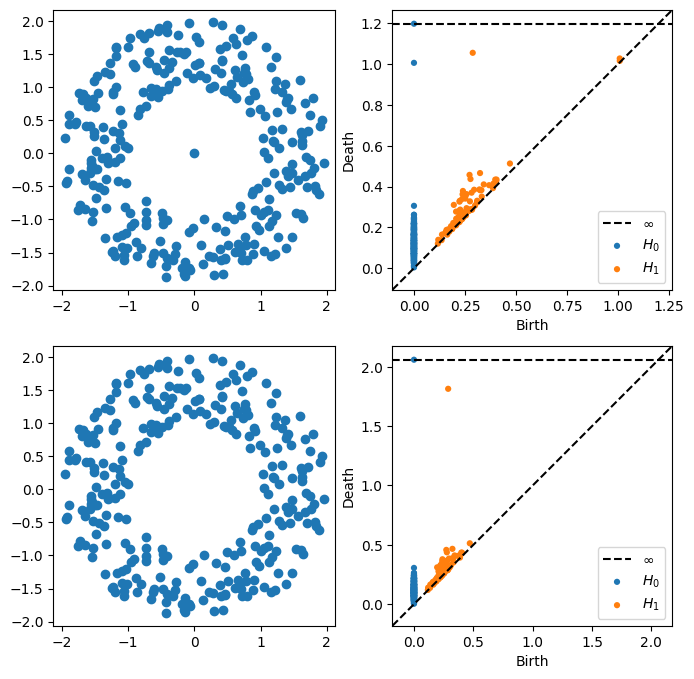

In [33]:

fig, axs = plt.subplots(2,2, figsize = (8,8))
plt.sca(axs[0,0])
Draw.drawPtCloud(Q)
plt.axis('equal')
plt.sca(axs[0,1])
plot_diagrams(DgmsQ)

plt.sca(axs[1,0])
Draw.drawPtCloud(P)
plt.axis('equal')
plt.sca(axs[1,1])
plot_diagrams(DgmsP)

<div style="border:2px solid #e74c3c; border-radius:8px; padding:1em; background:#fff6f6;color:#000000; width:80%">
<span style="color:#e74c3c; font-weight:bold;">Q:</span> 
<ul>
<li> What changes in the persistence diagram when you add the point? </li>
</ul>
</div>